In [57]:
import numpy as np
import pandas as pd
from typing import Union
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/jj.csv')
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


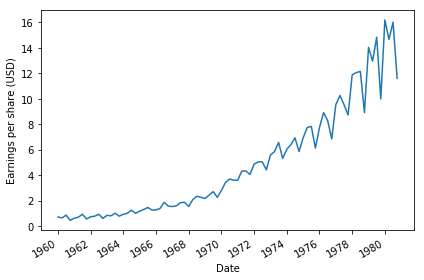

In [6]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
plt.xticks(
    np.arange(0, 81, 8),
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
)
fig.autofmt_xdate()
plt.tight_layout()

In [8]:
ADF_result = adfuller(df['data'])
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: 2.742016573457474
p-value: 1.0


Our series is not **stationary**

In [9]:
eps_diff = np.diff(df['data'], n=1)
ADF_result = adfuller(eps_diff)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -0.40740976363801973
p-value: 0.9088542416911349


Our series is not **stationary**

In [10]:
eps_diff2 = np.diff(df['data'], n=2)
ADF_result = adfuller(eps_diff2)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -3.585162874793191
p-value: 0.006051099869602951


Our series is **stationary**

In [12]:
def optimize_ARIMA(
    endog: Union[pd.Series, list],
    order_list: list,
    d: int
) -> pd.DataFrame:
    
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q)', 'AIC']
    
    # sort
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [14]:
ps = range(0, 4)
qs = range(0, 4)
d = 2

order_list = list(product(ps, qs))

In [15]:
train = df['data'][:-4]
result_df = optimize_ARIMA(train, order_list, d)
result_df

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


,"(p, q)",AIC
0,"(3, 3)",115.270775
1,"(3, 1)",115.624980
2,"(3, 2)",115.672008
3,"(3, 0)",154.430741
4,"(0, 3)",194.654716
5,"(0, 2)",209.274628
6,"(2, 3)",220.666862
7,"(1, 3)",228.267793
8,"(1, 2)",228.935790
9,"(2, 2)",229.974654


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


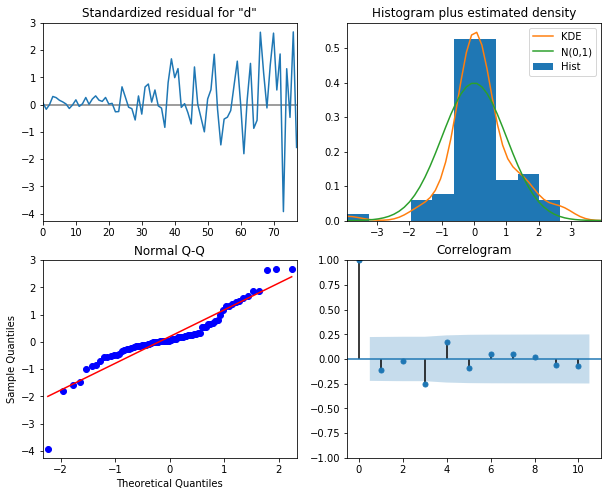

In [22]:
model = SARIMAX(train, order=(3, 2, 3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));

In [23]:
residuals = model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11))
pvalue

array([0.19933121, 0.43848728, 0.06427498, 0.05560557, 0.07964348,
       0.12141389, 0.17092574, 0.24065386, 0.29673547, 0.34561623])

ARIMA(3,2,3) model has passed all the checks, and it can now be used for forecasting

In [24]:
test = df[-4:]
test

,date,data
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [26]:
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [30]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
test['ARIMA_pred'] = ARIMA_pred
test

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.855569
81,1980-04-01,14.67,12.96,14.378015
82,1980-07-02,16.02,14.85,16.367924
83,1980-10-01,11.61,9.99,11.682058


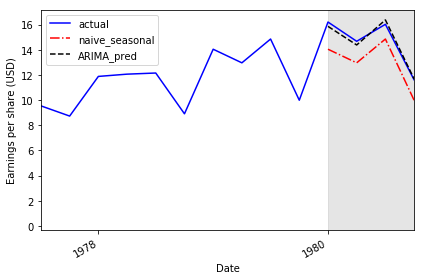

In [38]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['data'], 'b-', label='actual')
ax.plot(test['date'], test['naive_seasonal'], 'r-.', label='naive_seasonal')
ax.plot(test['date'], test['ARIMA_pred'], 'k--', label='ARIMA_pred')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc=2)
plt.xticks(
    np.arange(0, 81, 8),
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
)
ax.set_xlim(70, 83)
ax.axvspan(80, 83, color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

In [39]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])
print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7272337218825495


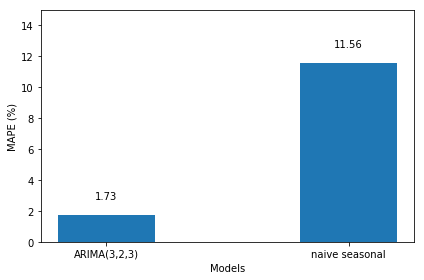

In [56]:
fig, ax = plt.subplots()
x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y[::-1]):
    plt.text(x=index, y=value + 1, s=str(round(value, 2)), ha='center')
    
plt.tight_layout()

In [58]:
mae_naive = mean_absolute_error(test['data'], test['naive_seasonal'])
mae_ARIMA = mean_absolute_error(test['data'], test['ARIMA_pred'])
print(mae_naive, mae_ARIMA)

1.6649999999999996 0.2640994219175363
